In [1]:
import pandas as pd
import numpy as np
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import umap
from sklearn.decomposition import PCA

import sys
# sys.path.insert(0, '')
import importlib
from dredFISH.Analysis import basicu

importlib.reload(basicu)

sns.set_context('talk')

# Load data

In [2]:
f = '../data_dump/candidate_genes_vincent_0328.csv'
df0 = pd.read_csv(f)
df0 = df0.sort_values(['Subclass', 'Type/Gradient'])
df0 = df0[df0['Gene']!='Neurod1']
df0 = df0.set_index('Gene')
df0

,Subclass,Type/Gradient,Function,Priority,Note
Gene,,,,,
Baz1a,L2/3,A<B>C,TF,***,NaN
Trpc6,L2/3,A<B>C,IC,***,NaN
Bdnf,L2/3,A<B>C,CAM,***,NaN
Sox5,L2/3,A<B>C,TF,NaN,NaN
Nrp1,L2/3,A<B>C,CAM,***,NaN
...,...,...,...,...,...
Ngb,L2/3,NaN,other,NaN,NaN
Penk,L2/3,NaN,other,NaN,NaN
Chrm2,"L2/3, L4",C>B=A,IC,***,NaN


In [3]:
df0['Type/Gradient'].unique(), df0['Subclass'].unique()

(array(['A<B>C', 'A>B=C', 'A>B>C', 'A>C>B', 'C>A>B', 'C>B=A', 'C>B>A',
        'Type A', 'Type C', 'all', nan], dtype=object),
 array(['L2/3', 'L2/3, L4', 'L4'], dtype=object))

In [4]:
%%time
adata = ad.read('/bigstore/GeneralStorage/fangming/projects/visctx/data_dump/P38_glut_genes_v2.h5ad')
adata

CPU times: user 147 ms, sys: 888 ms, total: 1.03 s
Wall time: 1.05 s


AnnData object with n_obs × n_vars = 5837 × 86
    obs: 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet', 'Doublet Score', 'cluster', 'Class_broad', 'sample', 'Age', 'subclass', 'layer', 'Type', 'Subclass'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Type_colors', 'cluster_colors', "dendrogram_['leiden']", 'hvg', 'layer_colors', 'leiden', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

# Explore cluster level

In [5]:
Xk, xclsts = basicu.group_mean(adata.X, adata.obs['cluster'].values,)
Xk = np.array(Xk)
Xk = pd.DataFrame(Xk, index=xclsts, columns=adata.var.index.values)
Xk.shape, xclsts.shape, xclsts

((6, 86),
 (6,),
 array(['L2/3_A', 'L2/3_B', 'L2/3_C', 'L4_A', 'L4_B', 'L4_C'], dtype=object))

In [6]:
Xplot = Xk.T #[gene_order].T
mat, rows, cols = basicu.diag_matrix_rows(Xplot.values)
Xplot = pd.DataFrame(mat, index=Xplot.index.values[rows], columns=Xplot.columns.values[cols])
Xannot = df0.loc[Xplot.index][['Subclass', 'Type/Gradient', 'Function', 'Priority']].fillna('')

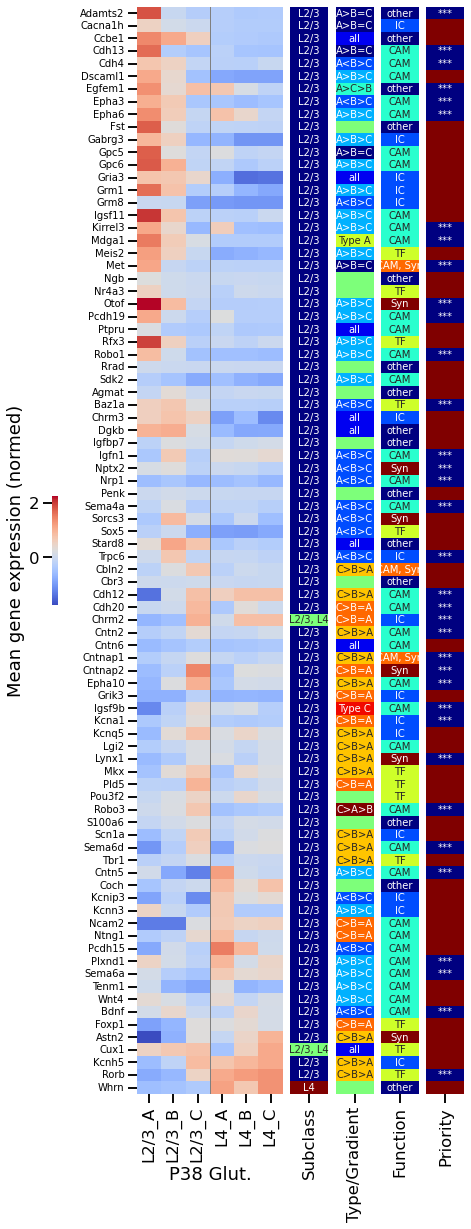

In [7]:
mosaic = "A"*6+"BCDE"
fig, axs = plt.subplot_mosaic(mosaic, figsize=(8,20))
ax = axs['A']
sns.heatmap(Xplot, 
            xticklabels=True,
            yticklabels=True,
            cmap='coolwarm', 
            cbar_kws=dict(shrink=0.1, label='Mean gene expression (normed)', location='left', pad=0.3),
            ax=ax)
ax.axvline(3, color='gray', linewidth=1)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
ax.set_xlabel('P38 Glut.')

for i, ax in enumerate([axs['B'], axs['C'], axs['D'], axs['E']]):
    nums, catgs = pd.factorize(Xannot.iloc[:,i])
    # ax.set_title(Xannot.columns[i], fontsize=12, rotation=90)
    sns.heatmap(nums.reshape(-1,1), 
                annot=pd.Series(catgs.values[nums]).values.reshape(-1,1),
                annot_kws={'size': 10},
                yticklabels=False,
                # xticklabels=False,
                fmt='',
                cbar=False,
                cmap='jet',
                ax=ax
               )
    ax.set_xticklabels([Xannot.columns[i]], rotation=90)

plt.show()

# UMAP

In [8]:
%%time

# UMAP
embed = umap.UMAP(n_components=2, random_state=0).fit_transform(adata.X)
adata.obs['embed_1'] = embed[:,0]
adata.obs['embed_2'] = embed[:,1]

embed.shape

CPU times: user 45.4 s, sys: 3.62 s, total: 49 s
Wall time: 29.5 s


(5837, 2)

In [9]:
# PCA
pca = PCA(n_components=None).fit(adata.X)
pca_v = pca.explained_variance_ratio_
pcX = pca.transform(adata.X)

loading1 = pca.components_[0,:]
loading2 = pca.components_[1,:]
geneidxrank1 = np.argsort(np.abs(loading1))[::-1]
geneidxrank2 = np.argsort(np.abs(loading2))[::-1]

for i in np.arange(pcX.shape[1]):
    adata.obs[f'PC_{i+1}'] = pcX[:,i]

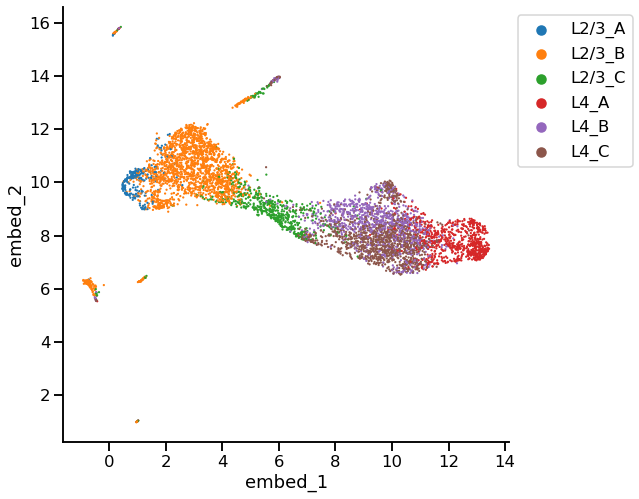

In [10]:
fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(data=adata.obs, 
                x='embed_1',
                y='embed_2',
                hue='cluster',
                hue_order=np.sort(adata.obs['cluster'].unique()),
                edgecolor='none',
                s=5,
                ax=ax,
               )
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
sns.despine(ax=ax)
plt.show()

(0.0, 1.0)

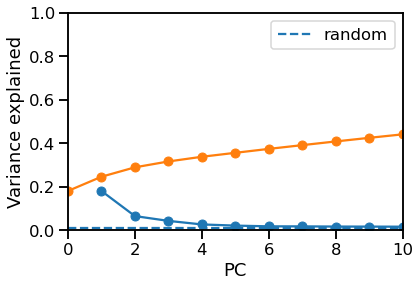

In [11]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(pca_v))+1, pca_v, '-o')
ax.axhline(1/len(pca_v), label='random', linestyle='--')
ax.set_xlabel('PC')
ax.set_ylabel('Variance explained')
ax.set_xlim([0,10])
ax.legend()

plt.plot(np.cumsum(pca_v), '-o')
plt.ylim([0,1])

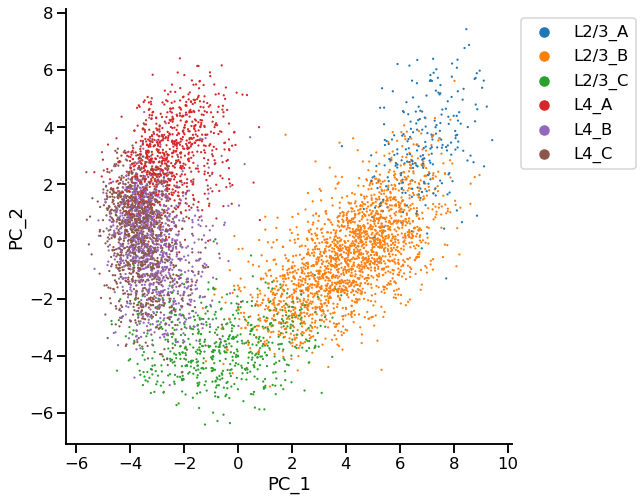

In [12]:
fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(data=adata.obs, 
                x='PC_1',
                y='PC_2',
                hue='cluster',
                hue_order=np.sort(adata.obs['cluster'].unique()),
                edgecolor='none',
                s=5,
                ax=ax,
               )
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
sns.despine(ax=ax)
plt.show()

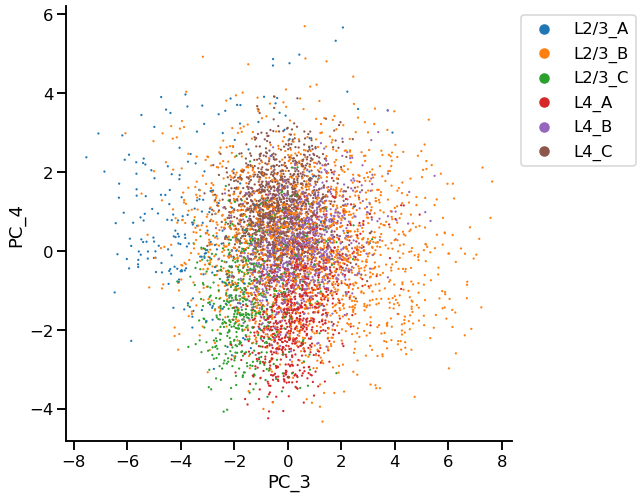

In [13]:
fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(data=adata.obs, 
                x='PC_3',
                y='PC_4',
                hue='cluster',
                hue_order=np.sort(adata.obs['cluster'].unique()),
                edgecolor='none',
                s=5,
                ax=ax,
               )
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
sns.despine(ax=ax)
plt.show()

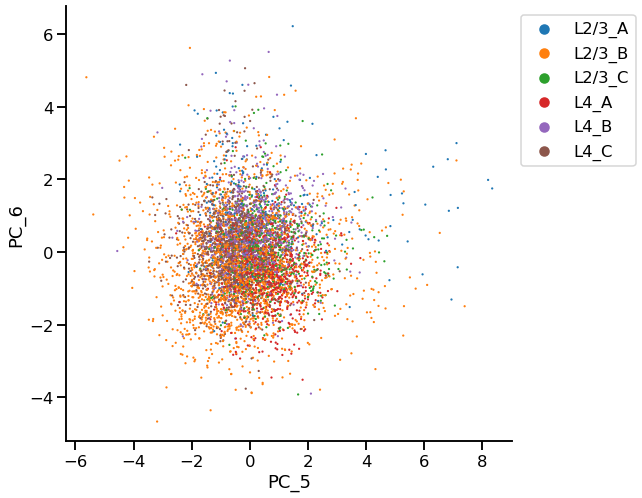

In [14]:
fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(data=adata.obs, 
                x='PC_5',
                y='PC_6',
                hue='cluster',
                hue_order=np.sort(adata.obs['cluster'].unique()),
                edgecolor='none',
                s=5,
                ax=ax,
               )
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
sns.despine(ax=ax)
plt.show()

Text(0.5, 102.296875, 'P38 Glut.')

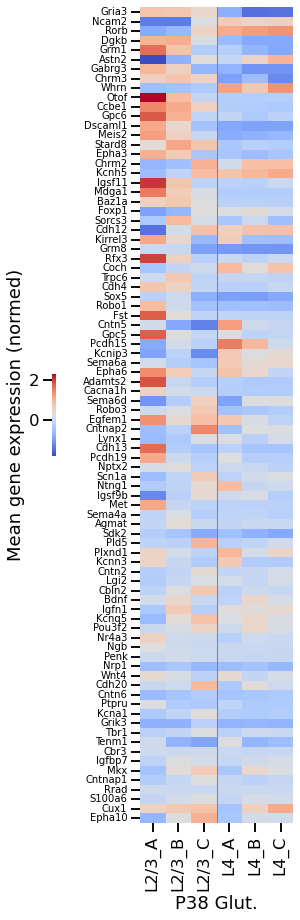

In [15]:
fig, ax = plt.subplots(figsize=(5,15))
sns.heatmap(Xk.T.iloc[geneidxrank1], 
            xticklabels=True,
            yticklabels=True,
            cmap='coolwarm', 
            cbar_kws=dict(shrink=0.1, label='Mean gene expression (normed)', location='left', pad=0.3),
            ax=ax)
ax.axvline(3, color='gray', linewidth=1)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
ax.set_xlabel('P38 Glut.')

Text(0.5, 102.296875, 'P38 Glut.')

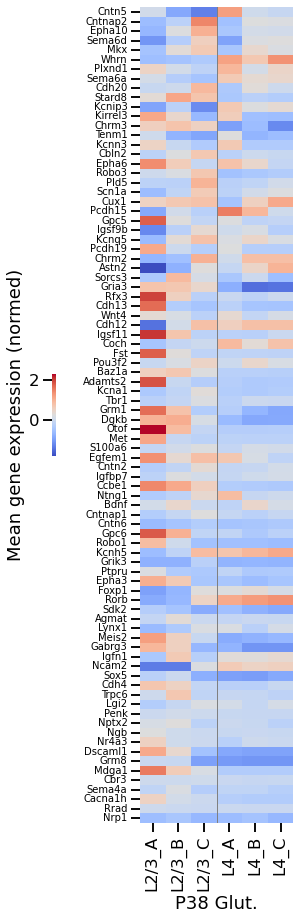

In [16]:
fig, ax = plt.subplots(figsize=(5,15))
sns.heatmap(Xk.T.iloc[geneidxrank2], 
            xticklabels=True,
            yticklabels=True,
            cmap='coolwarm', 
            cbar_kws=dict(shrink=0.1, label='Mean gene expression (normed)', location='left', pad=0.3),
            ax=ax)
ax.axvline(3, color='gray', linewidth=1)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
ax.set_xlabel('P38 Glut.')

# use L2/3 only?

In [17]:
adatasub = adata[adata.obs['cluster'].str.contains(r'L2/3')].copy()

In [18]:
pca = PCA(n_components=None).fit(adatasub.X)
pca_v = pca.explained_variance_ratio_

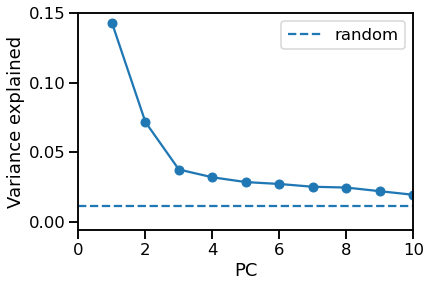

In [19]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(pca_v))+1, pca_v, '-o')
ax.axhline(1/len(pca_v), label='random', linestyle='--')
ax.set_xlabel('PC')
ax.set_ylabel('Variance explained')
ax.set_xlim([0,10])
ax.legend()


(0.0, 1.0)

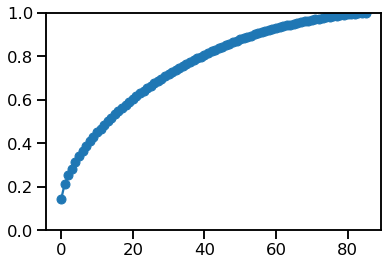

In [20]:
plt.plot(np.cumsum(pca_v), '-o')
plt.ylim([0,1])

In [21]:
pcX = pca.transform(adatasub.X)

In [22]:
for i in np.arange(pcX.shape[1]):
    adatasub.obs[f'PC_{i+1}'] = pcX[:,i]

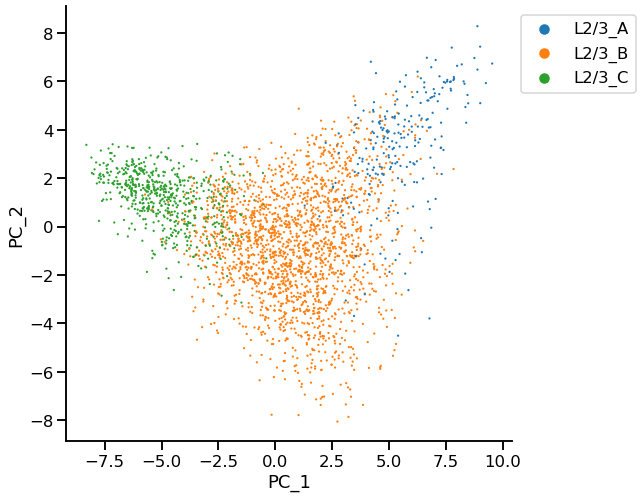

In [23]:
fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(data=adatasub.obs, 
                x='PC_1',
                y='PC_2',
                hue='cluster',
                hue_order=np.sort(adatasub.obs['cluster'].unique()),
                edgecolor='none',
                s=5,
                ax=ax,
               )
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
sns.despine(ax=ax)
plt.show()

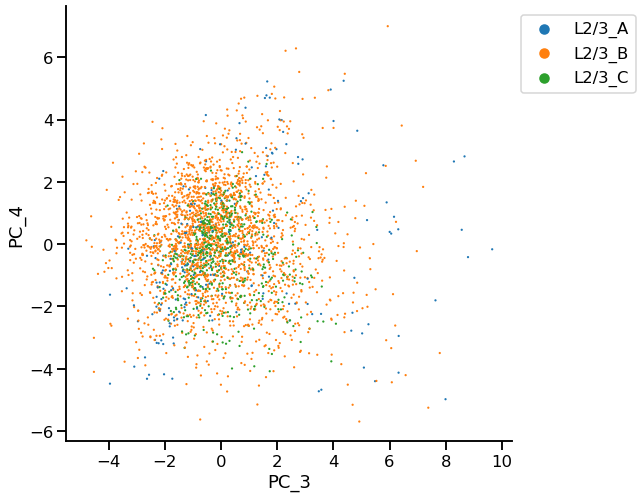

In [24]:
fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(data=adatasub.obs, 
                x='PC_3',
                y='PC_4',
                hue='cluster',
                hue_order=np.sort(adatasub.obs['cluster'].unique()),
                edgecolor='none',
                s=5,
                ax=ax,
               )
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
sns.despine(ax=ax)
plt.show()

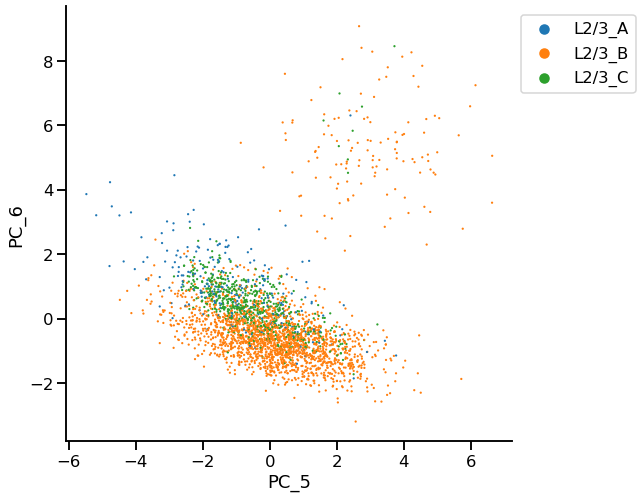

In [25]:
fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(data=adatasub.obs, 
                x='PC_5',
                y='PC_6',
                hue='cluster',
                hue_order=np.sort(adatasub.obs['cluster'].unique()),
                edgecolor='none',
                s=5,
                ax=ax,
               )
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
sns.despine(ax=ax)
plt.show()

In [26]:
pca.components_.shape, np.power(pca.components_, 2).sum(axis=1)

((86, 86),
 array([0.9999998 , 1.0000001 , 1.0000005 , 1.000001  , 0.99999964,
        0.99999994, 1.0000002 , 1.0000008 , 1.        , 1.0000006 ,
        1.        , 0.9999995 , 0.9999999 , 0.9999998 , 0.9999998 ,
        1.0000002 , 1.        , 1.        , 1.0000004 , 1.0000004 ,
        1.0000005 , 1.0000006 , 1.0000002 , 0.99999994, 0.99999994,
        1.0000002 , 1.0000001 , 0.9999999 , 1.0000002 , 0.9999998 ,
        1.0000002 , 0.99999946, 1.0000004 , 0.9999999 , 1.0000005 ,
        1.0000001 , 1.0000002 , 0.9999998 , 0.99999994, 0.99999934,
        0.9999998 , 1.0000004 , 1.        , 1.        , 1.0000002 ,
        0.99999976, 0.99999976, 0.99999934, 1.0000005 , 1.0000001 ,
        1.0000002 , 1.        , 0.99999994, 0.99999964, 0.9999992 ,
        0.9999997 , 1.0000001 , 1.0000004 , 1.        , 0.99999976,
        1.0000001 , 1.        , 0.9999998 , 0.99999976, 0.9999999 ,
        1.0000004 , 0.99999994, 0.9999999 , 1.0000004 , 1.0000007 ,
        0.9999997 , 0.99999994, 1.000

In [27]:
loading1 = pca.components_[0,:]
loading2 = pca.components_[1,:]

In [28]:

geneidxrank1 = np.argsort(np.abs(loading1))[::-1]
geneidxrank2 = np.argsort(np.abs(loading2))[::-1]

Text(0.5, 102.296875, 'P38 Glut.')

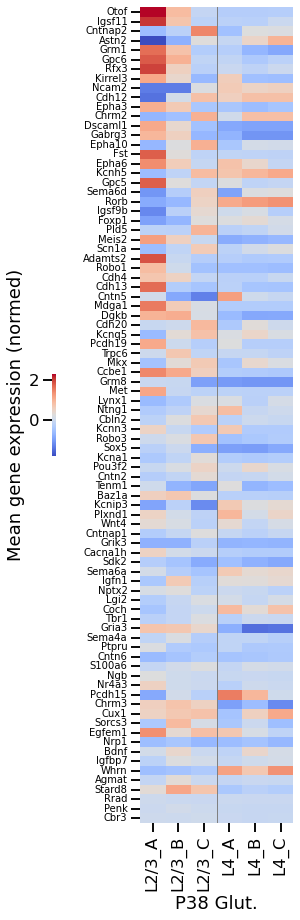

In [29]:
fig, ax = plt.subplots(figsize=(5,15))
sns.heatmap(Xk.T.iloc[geneidxrank1], 
            xticklabels=True,
            yticklabels=True,
            cmap='coolwarm', 
            cbar_kws=dict(shrink=0.1, label='Mean gene expression (normed)', location='left', pad=0.3),
            ax=ax)
ax.axvline(3, color='gray', linewidth=1)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
ax.set_xlabel('P38 Glut.')

Text(0.5, 102.296875, 'P38 Glut.')

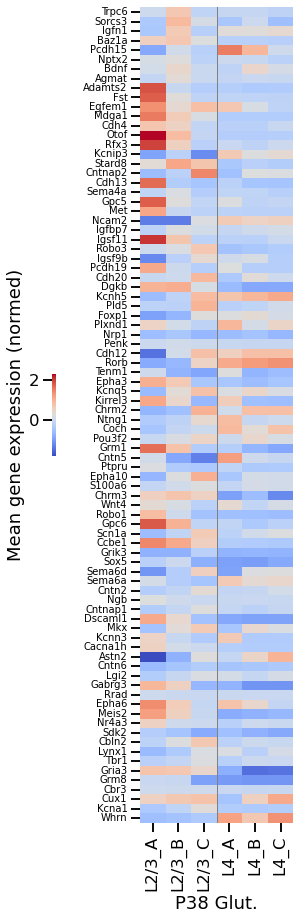

In [30]:
fig, ax = plt.subplots(figsize=(5,15))
sns.heatmap(Xk.T.iloc[geneidxrank2], 
            xticklabels=True,
            yticklabels=True,
            cmap='coolwarm', 
            cbar_kws=dict(shrink=0.1, label='Mean gene expression (normed)', location='left', pad=0.3),
            ax=ax)
ax.axvline(3, color='gray', linewidth=1)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
ax.set_xlabel('P38 Glut.')

# Try LASSO
- L2/3 vs L4
- L2/3 subtypes
- continuum (UMAP_1 as a proxy)

In [31]:
adata.write('../data_dump/P38_glut_genes_v2_annot.h5ad')